In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

In [2]:
# importer les packages
# common
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
# ml
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FactorAnalysis
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import davies_bouldin_score as dbsc
from clusteval import clusteval
from kmodes.kmodes import KModes
# plot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')
%matplotlib inline

10:80: E501 line too long (98 > 79 characters)
14:80: E501 line too long (92 > 79 characters)
1: E999 SyntaxError: invalid syntax


In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
# récupérer les données "brutes"
data = pd.read_csv('Data/data.csv')

In [5]:
# passer le customer_unique_id en index
data = data.rename(index=data['customer_unique_id'])

Attention si on veut conserver le feature customer_unique_id car il a disparu (nouvel index)

In [6]:
data.sample(3)

,order_purchase_year,order_purchase_month,purchase_time_zone_cat,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,total_price,freight_percentage,...,customer_state,cust_sell_dist,cust_sell_dist_lvl,review_answer_delay,review_answer_delay_lvl,product_review_mean,product_review_mean_lvl,customer_review_mean,review_gap,review_gap_lvl
1b6d5b92615ec6c0d7dafa4002ba63be,2018,2,AM-WD,13,4,Later_Delivery,single_item,single_product,39.9,23.825888,...,SP,81.743802,Near_Dist,3,Late_Answer,3.266667,Low_Score,5.0,1.733333,Better_Review
e38c47db3257aeae6d34aa6a973025ec,2017,6,PM-WD,13,10,Nominal_Delivery,single_item,single_product,34.9,28.775510,...,RJ,335.353785,AroundMed_Dist,1,Early_Answer,2.000000,Low_Score,2.0,0.000000,Same_Review
2a9b18ca6a5ece50564a6c3bbd4edb5f,2018,1,Evening-WD,6,19,Sooner_Delivery,single_item,single_product,69.9,14.641592,...,SP,302.391104,Near_Dist,3,Late_Answer,3.666667,Low_Score,5.0,1.333333,Better_Review


In [7]:
# répartition des ventes par catégorie de produit
df_sales_categ = data.groupby(
    'product_cat',
    as_index=False).agg({'total_price': ['sum']})
df_sales_categ.columns = ['product_cat',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)


In [8]:
df_sales_categ.reindex(np.arange(len(df_sales_categ.index)))

,product_cat,sales
0,Auto,525320.20
1,Construction & Tools,738532.93
2,Corporate,142441.11
3,Electronics Computers & Accessories,1149637.73
4,Entertainement,457758.16
5,Fashion,294877.82
6,Food Drink & Pets,251918.07
7,Furniture,946629.74
8,Health Beauty Baby,1856578.31
9,Home Accessories,882485.06


[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

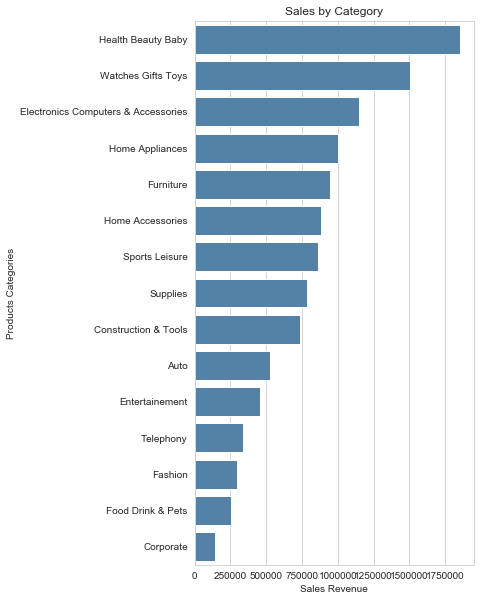

5:80: E501 line too long (80 > 79 characters)


In [9]:
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ.sort_values(by=['sales'], ascending=False))
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

In [10]:
# vérifier les colonnes numériques
data.select_dtypes(include='number').columns

Index(['order_purchase_year', 'order_purchase_month',
       'effective_delivery_time', 'delivery_vs_estimated', 'total_price',
       'freight_percentage', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'product_photos_qty_lvl', 'payment_sequence_size',
       'payment_installments_size', 'cust_sell_dist', 'review_answer_delay',
       'product_review_mean', 'customer_review_mean', 'review_gap'],
      dtype='object')

In [11]:
# sortie du type number mois et année - pour découpages temporels
for i in ['order_purchase_year',
          'order_purchase_month']:
    data[i] = data[i].astype('object')

In [12]:
lvl_features = data.columns[data.columns.str.contains('_lvl')].tolist()

In [13]:
# ranger en catégoriel
for i in lvl_features:
    data[i] = data[i].astype('category')

In [14]:
# features catégoriels
cat_features = data.columns[data.columns.str.contains('_cat')].tolist()

In [15]:
# ranger en catégoriel
for i in cat_features:
    data[i] = data[i].astype('category')

In [16]:
data.select_dtypes(include='category').columns.size

15

In [17]:
numerical_features = data.select_dtypes(include='number').columns

In [18]:
categorical_features = data.select_dtypes(include='category').columns

In [19]:
numerical_pipeline = Pipeline(steps=[
    ('rankgauss', QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal'))])
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
# step de transformation selon la nature des features
mytransformer = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)])


In [21]:
myclusterer = Pipeline(
    [
        (
            'hclust',
            AgglomerativeClustering(n_clusters=3)
        ),
    ])

In [22]:
# définition du pipe 2 steps
mypipe = Pipeline(steps=[('transformer', mytransformer),
                         ('clusterer', myclusterer)])

In [23]:
data = data.select_dtypes(include=['number', 'category'])

In [24]:
data.sample(3)

,purchase_time_zone_cat,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,total_price,freight_percentage,freight_percentage_lvl,total_price_lvl,charmed_price_cat,product_name_length,...,payment_lvl,cust_sell_dist,cust_sell_dist_lvl,review_answer_delay,review_answer_delay_lvl,product_review_mean,product_review_mean_lvl,customer_review_mean,review_gap,review_gap_lvl
27f533c49caf7f299c1567e655d1da67,WE,4,13,Nominal_Delivery,59.0,23.366671,Nominal_FreightCost,D,Charmed_Price,58.0,...,UnderMed_Payment,494.019601,AroundMed_Dist,0,Early_Answer,5.000000,Top_Score,5.0,0.000000,Same_Review
e6018d53527125cc1dc00cd86e66df82,Evening-WD,14,19,Sooner_Delivery,89.0,16.721250,Nominal_FreightCost,D,Charmed_Price,59.0,...,UnderMed_Payment,756.546255,Far_Dist,1,Early_Answer,4.375000,Medium_Score,5.0,0.625000,Better_Review
c66af225ef91fe505b5c089833b36662,AM-WD,6,5,Later_Delivery,144.9,8.764639,Low_FreightCost,E,Charmed_Price,59.0,...,OverMed_Payment,16.212061,Near_Dist,1,Early_Answer,3.666667,Low_Score,4.0,0.333333,Better_Review


In [25]:
# echantillonnage (10%)
data_sample = pd.DataFrame(data).sample(
    int(data.shape[0]/10),
    random_state=42)
data_sample.shape

(8708, 31)

In [26]:
mypipe.fit(data_sample)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('rankgauss',
                                                                   QuantileTransformer(n_quantiles=100,
                                                                                       output_distribution='normal',
                                                                                       random_state=1111))]),
                                                  Index(['effective_delivery_time', 'delivery_vs_estimated', 'total_price',
       'freight_percentage', 'product_name_length',
       'product_description_length', 'product_photos_qty',...
       'freight_percentage_lvl', 'total_price_lvl', 'charmed_price_cat',
       'product_photos_qty_lvl', 'product_cat', 'payment_sequence_size_cat',
       'payment_installment_size_cat', 'main_payment_type_cat', 'payment_lvl',
       'cust_sell_dist_lvl', 'rev

In [27]:
preprocessed_data = pd.DataFrame(mypipe['transformer'].transform(data_sample))

In [28]:
preprocessed_data

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.101452,-0.430727,-1.813516,1.500455,-0.444660,-1.853604,-5.199338,-0.816627,-0.216904,-5.199338,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.101452,-0.295415,-1.388485,1.394822,-2.124001,0.239615,0.242903,-1.029957,-0.870846,-5.199338,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.472789,-0.037988,-1.875627,1.582400,-0.714776,-2.186911,-5.199338,-1.399657,-1.335178,-5.199338,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.037988,1.304923,1.470791,-0.792516,1.639976,1.949289,1.746017,-0.389414,-0.620878,-5.199338,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.101452,0.269066,-0.904656,0.824918,-0.515705,-0.191052,0.698526,-0.101452,-0.257998,-5.199338,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,-0.472789,0.698526,0.338341,-0.799078,-0.515705,2.082834,-5.199338,0.559592,0.413694,2.166107,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8704,-5.199338,-1.194396,-0.003122,-0.931965,-1.470545,1.120205,-5.199338,-0.556539,-0.216904,-5.199338,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8705,-1.508944,-0.889495,-1.168949,0.312632,1.144237,0.694612,-5.199338,-1.399657,-0.661596,-5.199338,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8706,-0.967422,0.269066,0.604585,-0.988736,0.025322,-1.571091,-5.199338,0.698526,0.349714,-5.199338,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [29]:
preprocessed_data = mypipe['transformer'].transform(data_sample)

In [30]:
hclust_labels = mypipe['clusterer']['hclust'].fit_predict(preprocessed_data)

In [31]:
data_sample['clusters'] = hclust_labels

In [32]:
metrics.silhouette_score(preprocessed_data, hclust_labels)

0.11970146130732565

In [33]:
dbsc(preprocessed_data, hclust_labels)

2.473433882821156

Text(0.5, 1.02, 'Cluster nb')

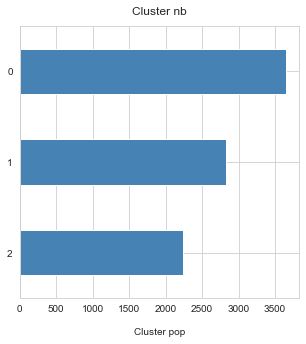

In [34]:
# observer la répartition des effectifs dans les clusters
data_sample['clusters'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

## Proposition de visualisations caractérisant les clusters

In [35]:
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [36]:
data_sample.sample(3)

,purchase_time_zone_cat,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,total_price,freight_percentage,freight_percentage_lvl,total_price_lvl,charmed_price_cat,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_photos_qty_lvl,product_cat,payment_sequence_size,payment_installments_size,payment_sequence_size_cat,payment_installment_size_cat,main_payment_type_cat,payment_lvl,cust_sell_dist,cust_sell_dist_lvl,review_answer_delay,review_answer_delay_lvl,product_review_mean,product_review_mean_lvl,customer_review_mean,review_gap,review_gap_lvl,clusters
b312ad624f97da964dcedfedc0f302ed,PM-WD,12,22,Sooner_Delivery,169.90,12.530890,Low_FreightCost,E,Charmed_Price,56.0,1123.0,4.0,1533.0,16224.0,4,Health Beauty Baby,1.0,3.0,mono_payment,single_payment,Credit_Card_PayType,Heavy_Payment,1173.876199,Far_Dist,1,Early_Answer,3.947368,Low_Score,5.0,1.052632,Better_Review,2
d0be30ee664f00c5b5c654790208e0e2,WE,9,15,Sooner_Delivery,12.97,53.794086,High_FreightCost,B,Charmed_Price,49.0,1568.0,1.0,150.0,1188.0,1,Telephony,1.0,1.0,mono_payment,single_payment,Credit_Card_PayType,Light_Payment,553.699707,AroundMed_Dist,1,Early_Answer,5.000000,Top_Score,5.0,0.000000,Same_Review,0
400028a363e9857f1e56833f2be713a5,Evening-WD,10,30,Sooner_Delivery,199.00,19.504894,Nominal_FreightCost,E,Charmed_Price,59.0,993.0,5.0,7750.0,37026.0,5,Supplies,1.0,8.0,mono_payment,single_payment,Credit_Card_PayType,Heavy_Payment,731.022274,Far_Dist,1,Early_Answer,4.500000,Medium_Score,5.0,0.500000,Better_Review,2


In [37]:
# niveau des ventes par purchase_time_zone x clusters
data_clusters = data_sample.groupby(['clusters'],
    as_index=False).agg({'total_price': ['mean'],
                         'customer_review_mean': ['mean'],
                         'cust_sell_dist': ['mean']})
data_clusters.columns = ['clusters',
                         'avg_price',
                         'avg_review_score',
                         'avg_cust_sell_dist']

3:5: E128 continuation line under-indented for visual indent


In [38]:
data_clusters

,clusters,avg_price,avg_review_score,avg_cust_sell_dist
0,0,139.026302,4.997502,563.387686
1,1,129.641598,2.915337,621.249850
2,2,139.003697,4.520638,589.946908


In [39]:
# découpage par cluster
data_sample_clust0 = data_sample[data_sample['clusters'] == 0]
data_sample_clust0.name = 'cluster 0'
data_sample_clust1 = data_sample[data_sample['clusters'] == 1]
data_sample_clust1.name = 'cluster 1'
data_sample_clust2 = data_sample[data_sample['clusters'] == 2]
data_sample_clust2.name = 'cluster 2'

In [40]:
def SalesClust(data):
    SalesClust = data.groupby(
        'product_cat',
        as_index=False).agg({'total_price': ['sum']})
    SalesClust.columns = ['product_cat',
                          'sales']
    SalesClust = SalesClust.sort_values(by=['sales'],
                                        ascending=False)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.barplot(y='product_cat',
                     x='sales',
                     color='Steelblue',
                     data=SalesClust.sort_values(by=['sales'],
                                        ascending=False))
    ax.set(xlabel='Sales Revenue',
           ylabel='Products Categories',
           title='Top 5 Sales by Category : ' + str(data.name))

9:1: W293 blank line contains whitespace
15:41: E128 continuation line under-indented for visual indent


In [41]:
SalesClust2 = data_sample_clust2.groupby(
        'product_cat', as_index=False).agg({'total_price': ['sum']})

In [42]:
SalesClust2.columns = ['product_cat',
                          'sales']

2:27: E127 continuation line over-indented for visual indent


In [43]:
bidule = SalesClust2.sort_values(by=['sales'],
                                        ascending=False)

2:41: E127 continuation line over-indented for visual indent


In [44]:
bidule = bidule.reset_index(drop=True)
bidule

,product_cat,sales
0,Watches Gifts Toys,50138.17
1,Health Beauty Baby,49588.56
2,Home Appliances,31079.61
3,Supplies,25317.23
4,Electronics Computers & Accessories,23024.78
5,Furniture,21075.29
6,Sports Leisure,20868.26
7,Home Accessories,17845.19
8,Construction & Tools,17656.21
9,Auto,13965.75


In [45]:
truc = bidule[:5]
truc.shape

(5, 2)

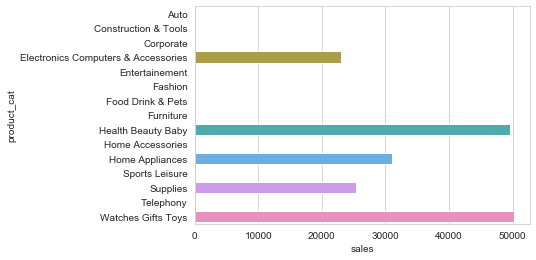

In [46]:
sns.barplot(x='sales', y=truc['product_cat'], data=truc)

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Top 5 Sales by Category : Cluster2')]

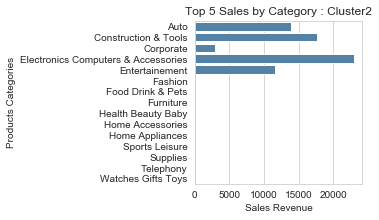

3:22: E127 continuation line over-indented for visual indent
4:22: E127 continuation line over-indented for visual indent
5:22: E127 continuation line over-indented for visual indent
7:12: E127 continuation line over-indented for visual indent
8:12: E127 continuation line over-indented for visual indent


In [47]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.barplot(y='product_cat',
                     x='sales',
                     color='Steelblue',
                     data=SalesClust2[:5])
ax.set(xlabel='Sales Revenue',
           ylabel='Products Categories',
           title='Top 5 Sales by Category : Cluster2')

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

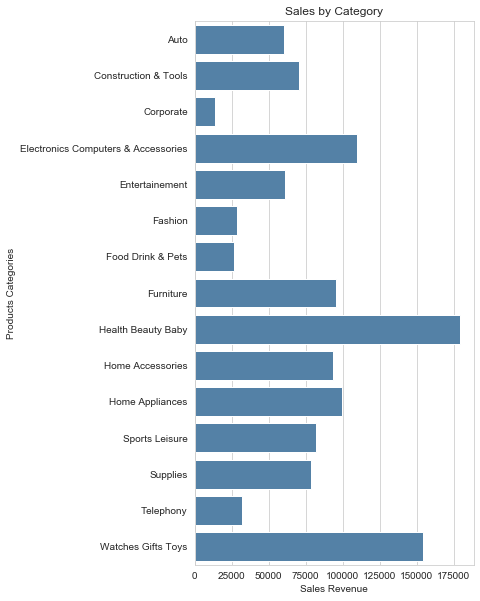

In [48]:
# répartition des ventes par catégorie de produit
df_sales_categ = data_sample.groupby(
    'product_cat',
    as_index=False).agg({'total_price': ['sum']})
df_sales_categ.columns = ['product_cat',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

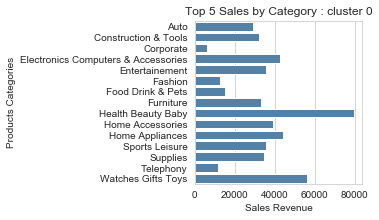

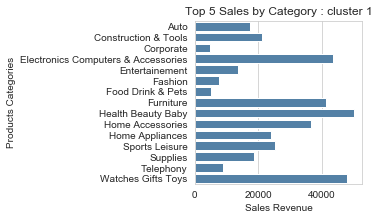

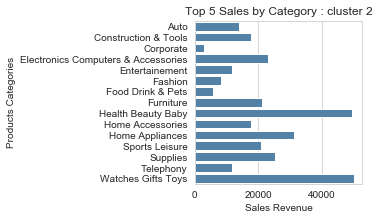

In [49]:
for i in [data_sample_clust0, data_sample_clust1, data_sample_clust2]:
    SalesClust(i)

In [50]:
# niveau des ventes par purchase_time_zone x clusters
data_sales_time_zone = data_sample.groupby(
    ['purchase_time_zone_cat', 'clusters'],
    as_index=False).agg({'total_price': ['sum']})
data_sales_time_zone.columns = ['purchase_time_zone_cat',
                                'clusters',
                                'sales']

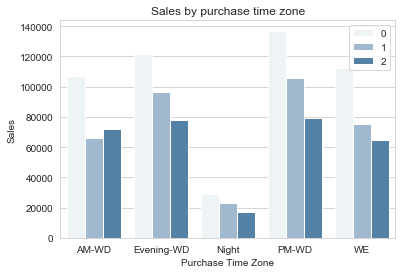

In [51]:
# afficher l'histogramme
ax = sns.barplot(x='purchase_time_zone_cat',
                 y='sales',
                 hue='clusters',
                 color='Steelblue',
                 data=data_sales_time_zone)
ax.set(xlabel='Purchase Time Zone',
       ylabel='Sales',
       title='Sales by purchase time zone')
plt.legend(loc='upper right')

In [52]:
# search_space 1 modèle
# mysearch_space = [{'clusterer': [AgglomerativeClustering()],
#                   'clusterer__linkage': ['complete', 'ward'],
#                   'clusterer__n_clusters': list(range(1, 3))}]

Ancienne version sans pipe avec une instance réussie du Gridsearch sans cv

In [53]:
# calcul du score - davies-bouldin


def my_cv_dbsc(estimator, X):
    estimator.fit(X)
    return dbsc(X, estimator.labels_)



In [54]:
# grid pour l'agglomerative_clustering
param_grid = {
    'linkage': ['complete',
                'ward'],
    'n_clusters': list(range(2, 6))
}


In [55]:

gs = GridSearchCV(estimator=AgglomerativeClustering(),
                  param_grid=param_grid,
                  scoring=my_cv_dbsc,
                  cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=42),
                  n_jobs=-1)


In [56]:
gs.fit(preprocessed_data)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.01, train_size=None),
             estimator=AgglomerativeClustering(), n_jobs=-1,
             param_grid={'linkage': ['complete', 'ward'],
                         'n_clusters': [2, 3, 4, 5]},
             scoring=<function my_cv_dbsc at 0x00000253A6D57DC8>)

In [57]:
gs.cv_results_

{'mean_fit_time': array([15.67908764, 16.34530807, 15.7868011 , 15.64019156, 15.03182006,
        15.02782822, 14.91413164, 15.35096669]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.07679462, 0.06682038, 0.07679296, 0.09474611, 0.00398731,
        0.00498676, 0.00598454, 0.00498533]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_linkage': masked_array(data=['complete', 'complete', 'complete', 'complete', 'ward',
                    'ward', 'ward', 'ward'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_clusters': masked_array(data=[2, 3, 4, 5, 2, 3, 4, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'linkage': 'complete', 'n_clusters': 2},
  {'linkage': 'complete', 'n_clusters': 3},
  {'linkage': 'complete', 'n_clusters': 4},
  {'lin

In [58]:
gs.best_params_

{'linkage': 'ward', 'n_clusters': 2}

In [59]:
gs.best_score_

2.1273004310553194

# Clustering hierarchique

##  Distances : Euclidienne, Mahalabonis, CityBlock
Observations sur des échantillons de 10 et 20% des données.

In [60]:
cl_eucl_10 = linkage(data_sel_sample10, method='complete', metric='euclidean')

NameError: name 'data_sel_sample10' is not defined

In [ ]:
cl_eucl_20 = linkage(data_sel_sample20, method='complete', metric='euclidean')

In [ ]:
cl_mahal_10 = linkage(data_sel_sample10, method='complete', metric='mahalanobis')

In [ ]:
cl_mahal_20 = linkage(data_sel_sample20, method='complete', metric='mahalanobis')

In [ ]:
cl_citybl_10 = linkage(data_sel_sample10, method='complete', metric='cityblock')

In [ ]:
cl_citybl_20 = linkage(data_sel_sample20, method='complete', metric='cityblock')

In [ ]:

def dendo(cl1, cl2, cl1_label, cl2_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.set_xlabel('Customers', fontsize=12)
    ax1.set_ylabel('Distance', fontsize=12)
    ax1.set_title('Dendrogram ' + cl1_label, fontsize=13)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    dendrogram(cl1,
               leaf_rotation=90,
               leaf_font_size=12,
               truncate_mode='lastp',
               show_leaf_counts=True,
               ax=ax1,
               )
    ax2.set_xlabel('Clients', fontsize=12)
    ax2.set_ylabel('Distance', fontsize=12)
    ax2.set_title('Dendrogram ' + cl2_label, fontsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    dendrogram(cl2,
               leaf_rotation=90,
               leaf_font_size=12,
               truncate_mode='lastp',
               show_leaf_counts=True,
               ax=ax2)
    plt.show()

In [ ]:
dendo(cl_eucl_10, cl_eucl_20, 'Euclidian_10', 'Euclidian_20')

In [ ]:
dendo(cl_mahal_10, cl_mahal_20, 'Mahalabonis_10', 'Mahalabonis_20')

In [ ]:
dendo(cl_citybl_10, cl_citybl_20, 'CityBlock_10', 'CityBlock_20')

- la claissification hiérachique la plus exploitable semble construire à partir de la distance euclidienne et s'améliore avec la taille de l'échantillon

In [ ]:
HClustLabels = fcluster(cl_mahal_20, 3, criterion='maxclust')

In [ ]:
HClust = data_sel_sample20.copy()

In [ ]:
HClust['clusters'] = HClustLabels

In [ ]:
HClust.sample(5)

In [ ]:
# projection des données sur les features
data_selection = data.filter(HClust_selection + cat_feat_order)
data_selection.shape

In [ ]:

search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


In [ ]:
# observer la répartition des effectifs dans les clusters
HClust['clusters'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

In [ ]:
HClust1 = HClust[HClust['clusters'] == 1]
HClust1.name = 'cluster 1'
HClust2 = HClust[HClust['clusters'] == 2]
HClust2.name = 'cluster 2'
HClust3 = HClust[HClust['clusters'] == 3]
HClust3.name = 'cluster 3'

In [ ]:
def SalesClust(data):
    SalesClust = data.groupby(
        'rational_category',
        as_index=False).agg({'payment_total': ['sum']})
    SalesClust.columns = ['rational_category',
                          'sales']
    SalesClust = SalesClust.sort_values(by=['sales'],
                                        ascending=False)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.barplot(y='rational_category',
                     x='sales',
                     color='Steelblue',
                     data=SalesClust[:5])
    ax.set(xlabel='Sales Revenue',
           ylabel='Products Categories',
           title='Top 5 Sales by Category : ' + str(data.name))

In [ ]:
for i in [HClust1, HClust2, HClust3]:
    SalesClust(i)

In [ ]:
label_color_map = {1: 'r',
                   2: 'k',
                   3: 'b'}

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(HClust['N_RG_payment_total'],
           HClust['N_RG_product_review_mean'],
           HClust['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=HClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Product Review Mean', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

In [ ]:
HClust.groupby('purchase_time_zone').clusters.value_counts().plot(
        kind='barh',
        color='steelblue',
        figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

- on conclue à une répartition homogène des achats par moment de la semaine

# PCA
On déroule une PCA en commençant par les features selectionnés

In [ ]:
data_selection.sample(3)

In [ ]:
# aperçu sur 2 dimensions
pca = PCA(n_components=2)
pca_n2 = pca.fit_transform(data_selection)
pca_df = pd.DataFrame(
    data=pca_n2, columns=['F1',
                          'F2'])

In [ ]:
# afficher les données selon les 2 dimensions
plt.scatter(pca_df['F1'], pca_df['F2'], alpha=.2)

In [ ]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

In [ ]:
# contribution des variables aux 2 composantes
pcs = pca.components_

fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, data_selection.columns[i])
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [ ]:
# avec 3 composants
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_selection)
principalDf = pd.DataFrame(
    data=principalComponents, columns=['F1',
                                       'F2',
                                       'F3'])

In [ ]:
# afficher les données selon les 3 dimensions
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('F1', fontsize=15)
ax.set_ylabel('F2', fontsize=15)
ax.set_zlabel('F3', fontsize=15)
ax.set_title('PCA n_components=3', fontsize=20)

ax.scatter(principalDf['F1'],
           principalDf['F2'],
           principalDf['F3'],
           s=60,
           alpha=0.2)
ax.grid()

In [ ]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

In [ ]:
# nombre optimal de components
pca = PCA()
pca.fit(data_selection)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


In [ ]:
display_scree_plot(pca)

In [ ]:
# projection des données sur les features
data_wide_selection = data.filter(std_feature_selection + cat_feat_order)
data_wide_selection.shape

In [ ]:
names = []
for i in range(1, 5):
    elt = 'F' + str(i)
    names.append(elt)

In [ ]:
pca_optimal = PCA(n_components=4)
principalComponents_optimal = pca_optimal.fit_transform(data_selection)
data_optimal = pd.DataFrame(
    data=principalComponents_optimal, columns=names, index=data_selection.index)

In [ ]:
data_optimal.head(5)

In [ ]:
sum(pca_optimal.explained_variance_ratio_)

# K - Means

on réalise un clustering k-means sur les données transformées / PCA

In [ ]:
sse = {}
# silhouette = {}
dbs = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_optimal)
    # silhouette[k] = metrics.silhouette_score(data_optimal,
    #                                         kmeans.labels_)
    sse[k] = kmeans.inertia_
    dbs[k] = metrics.davies_bouldin_score(
        data_optimal,
        kmeans.labels_)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(dbs.keys()),
         list(dbs.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

In [ ]:
# plt.title('Silhouette Score')
# sns.pointplot(x=list(silhouette.keys()), y=list(silhouette.values()))

In [ ]:
kmeans_optimal = KMeans(n_clusters=3, random_state=42)
kmeans_optimal.fit_predict(data_optimal)

In [ ]:
kmeans_optimal.inertia_

In [ ]:
# afficher les données selon les 2 dimensions
plt.scatter(data_optimal['F1'], data_optimal['F2'], c=kmeans_optimal.labels_.astype(np.float), cmap='viridis', alpha=.2)

In [ ]:
metrics.silhouette_score(data_optimal, kmeans_optimal.labels_)

- K-means à partir de données sans PCA

In [ ]:
sse = {}
# silhouette = {}
dbs = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_selection)
    # silhouette[k] = metrics.silhouette_score(data_selection,
    #                                         kmeans.labels_)
    sse[k] = kmeans.inertia_
    dbs[k] = metrics.davies_bouldin_score(
        data_selection,
        kmeans.labels_)

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(dbs.keys()),
         list(dbs.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

In [ ]:
plt.title('Davies-Bouldin Score')
sns.pointplot(x=list(dbs.keys()), y=list(dbs.values()))

In [ ]:
kmeans_optimal = KMeans(n_clusters=2, random_state=42)
kmeans_optimal.fit_predict(data_selection)

In [ ]:
kmeans_optimal.inertia_

In [ ]:
data_selection

In [ ]:
N_RG_payment_total
N_RG_freight_percentage
N_RG_charm_price
N_RG_review_gap
N_RG_delivery_vs_estimated
N_RG_cust_sell_dist

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_selection['N_RG_payment_total'],
           data_selection['N_RG_freight_percentage'],
           data_selection['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=kmeans_optimal.labels_)
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_selection['N_RG_payment_total'],
           data_selection['N_RG_review_gap'],
           data_selection['N_RG_delivery_vs_estimated'],
           cmap='plasma',
           c=kmeans_optimal.labels_)
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Review Gap', labelpad=15)
ax.set_zlabel('Rank-Gaussed Delivery vs Estimated')

# DBSCAN

In [ ]:
data_sample_20 = pd.DataFrame(data_selection).sample(
    int(data_selection.shape[0]/5),
    random_state=42)
data_sample_20.shape

In [ ]:
data_sample_20.sample(3)

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=1.7, min_samples=8, metric='cityblock').fit(data_sample_20)
labels = db.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
print('Silhouette Coefficient: %0.3f'
      % metrics.silhouette_score(data_sample_20, labels))

In [ ]:
data_sample_20['cluster_dbscan'] = labels

In [ ]:
data_sample_20['cluster_dbscan'].unique()

In [ ]:
# observer la répartition des effectifs dans les clusters
data_sample_20['cluster_dbscan'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

# K-Modes

Technique de Clustering dédiée aux features catégoriels. Son inconvenient majeur dans notre contexte, est que la proximité des catégories est perdue : dans le cas de plus de 2 catégories, cela implique que l'algorythme trouvera la même différence, par exemple, entre below median et over median, qu'entre below median et median, tandis que dans les faits, il y a une progression de below median vers over median.

Le principal intérêt est de fournir une description sans équivoque des centroids et une caractéristation très simple des clusters ainsis formés.

In [ ]:
# projection des données sur les features
mode_selection = ['eq_payment_lvl', 'price_charmed', 'purchase_time_zone', 'product_review_mean_lvl']
data_mode_selection = data.filter(mode_selection)
data_mode_selection.shape

In [ ]:
data_mode_selection.sample(3)

In [ ]:
km = KModes(n_clusters=4, init='Huang', n_init=50, verbose=1)

In [ ]:
clusters = km.fit_predict(data_mode_selection)

In [ ]:
# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
km10 = KModes(n_clusters=5, init='Huang', n_init=10, verbose=1)

In [ ]:
clusters10 = km10.fit_predict(data_mode_selection)

In [ ]:
# Print the cluster centroids
print(km10.cluster_centroids_)

In [ ]:
km10.labels_

In [ ]:
KModeClust = data.copy()

In [ ]:
KModeClust['clusters'] = km10.labels_

In [ ]:
# observer la répartition des effectifs dans les clusters
KModeClust['clusters'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(KModeClust['N_RG_payment_total'],
           KModeClust['N_RG_freight_percentage'],
           KModeClust['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=KModeClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(KModeClust['N_RG_payment_total'],
           KModeClust['N_RG_review_gap'],
           data_selection['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=KModeClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

In [ ]:
KModeClust.groupby('purchase_time_zone').clusters.value_counts().plot(
        kind='barh',
        color='steelblue',
        figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)